# Active-learning tutorial: zundel cation

## 1. Preparing and evaluating committee MACE models

In this tutorial, we will be preparing and working a **committee of MACE models** to describe two different **protonated water clusters** in the gas phase 
and illustrate the important aspects of committee-based active learning using **query by committee (QbC)**.

In the first part, we will leverage the accessible uncertainty measure to screen a wide pool of candidate geometries originating from a DFT simulation of the **Zundel cation** (H$_5$O$_2^+$) to **create a robust and concise training data set**.

In the second part, we will use the obtained model to perform an **exploratory simulation** of the related **Eigen cation** (H$_9$O$_3^+$) and, once again, rely on active learning to select the most relevant training structures
in order for the model to gain accuracy on a new, unexplored part of the configuration space.

In [1]:
from ase.io import read
from ase.visualize import view
view(read('../initial-datasets/zundel/~train.extxyz', index=0), viewer='x3d')

### 1.1 Prepare the notebook

This is all the modules and functions that we will need to run this tutorial.

Apart from standard python libraries, we built our own simple Query by Committee (QbC) functionality for this purpose which can be found (with additional helper tools) in `myfunctions.py`.

Having a developer-level understanding of these tools is not critical for completing the tutorial in any way,
but please do have a look if you are curious.

#### Import the necessary modules

In [2]:
import os                                         # set environment variable
from tqdm.notebook import tqdm                    # progress bar for Jupyter notebooks
from ase.io import read, write                    # read and write structures
import numpy as np                                # numerical operations
np.random.seed(0)                                 # set random seed for reproducibility
import matplotlib.pyplot as plt                   # plotting library
plt.style.use('notebook.mplstyle')                # use matplotlib style notebook.mplstyle
from scipy.stats import theilslopes               # Theil-Sen estimator for robust linear regression
try:
    
    from rich.console import Console              # rich console for better printing
    console = Console(width=200)
    print = console.print
except:
    print = print
    
from ipywidgets import interact, IntSlider        # interactive widgets for Jupyter notebooks
from scipy.stats import gaussian_kde              # Gaussian kernel density estimation

from myfunctions import train_mace                # train MACE model
from myfunctions import eval_mace                 # evaluate MACE model
from myfunctions import extxyz2array              # extract forces from extxyz file
from myfunctions import run_qbc                   # run Query by Committee
from myfunctions import prepare_train_file        # prepare training file for MACE
from myfunctions import forces2disagreement       # calculate disagreement in forces
from myfunctions import forces2rmse               # compute RMSE of forces

# README: you might see some warning messages: don't worry, they are not important

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


#### Global variables and hyperparameters

In the cell below we will select some hyperparameters of the employed MACE models and the QbC process.

In [4]:
# MACE committee
n_init_train = 20   # number of initial training structures
n_test       = 50   # number of test structures
n_committee  = 4    # number of MACE committee members
parallel     = False # whether to parallelize the training (this should work for Linux)

# QbC
n_iter_qbc = 10     # number of QbC iterations
n_add_iter = 10     # number of structures to add in each QbC iteration

# seeds to generate different MACE models
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

# folders
init_train_folder = "init-train"        # working folder for initial training
qbc_folder        = "qbc-work"          # working folder for QbC

### 1.2 Generating a training dataset

In the first part, we will tackle the Zundel cation using a committee of MACE models.
To actively select structures for the training set, we need to perform QbC on a provided candidate set.

The first step in QbC is to select a small number of random structures (here `n_init_train`) to train a very preliminary committee that can, however, already provide a measure of uncertainty.

We start by selecting these initial structures and, at the same time, separating out a small portion of our data points for testing purposes.

In [5]:
# create the necessary folders
os.makedirs(f'{init_train_folder}', exist_ok=True)                # initial training folder
os.makedirs(f'{init_train_folder}/config', exist_ok=True)         # folder with the config files used for training the MACE models
os.makedirs(f'{init_train_folder}/models', exist_ok=True)         # folder with the (final) trained MACE models
os.makedirs(f'{init_train_folder}/eval', exist_ok=True)           # folder where we will save the evaluation results
os.makedirs(f'{init_train_folder}/structures', exist_ok=True)     # folder with the training and test structures and other stuffs

# read the labeled structures from the extxyz file
structures = read('../initial-datasets/zundel/train.extxyz', index=':')
print(f'Total number of structures: {len(structures)}')

# Create the initial training datasets
selected_indices = np.random.choice(len(structures), size=(n_init_train + n_test), replace=False)
candidate_idcs = np.delete(np.arange(len(structures)), selected_indices)

indices_train = selected_indices[:n_init_train]
indices_test = selected_indices[n_init_train:]
assert len(indices_train) == n_init_train
assert len(indices_test) == n_test

# Training dataset
print(f"\nSelected indices for training:\n{indices_train}")
initial_training_set = [structures[i] for i in indices_train]
print(f"Saving the initial training set to '{init_train_folder}/structures/init.train.extxyz'")
write(f'{init_train_folder}/structures/init.train.extxyz', initial_training_set, format='extxyz')

# Test dataset
print(f"\nSelected indices for test:\n{indices_test}")
test_set = [structures[i] for i in indices_test]
print(f"Saving the test set to '{init_train_folder}/structures/test.extxyz'")
write(f'{init_train_folder}/structures/test.extxyz', test_set, format='extxyz')

# Candidates: remaining structures that are not in the initial training or test sets
candidates_structures = [structures[i] for i in candidate_idcs]
print(f"Saving the candidates structures to '{init_train_folder}/structures/candidates.extxyz'")
write(f'{init_train_folder}/structures/candidates.extxyz', candidates_structures, format='extxyz')

Total number of structures: 1000

Selected indices for training:
[800 311  85 435 204 833   1 781 457 299 851  27 618 466 880 711 403 945
 122 416]
Saving the initial training set to 'init-train/structures/init.train.extxyz'

Selected indices for test:
[487  14 983 981 399 715 626 389 298 279 436 890  31 731  45 720 249 358
 954 926 702 467  55 214 803 230 196 312 271 744 362 658 634 969 141 108
 356 821 520 317 384 775 966 558 364 601 710 320 471  75]
Saving the test set to 'init-train/structures/test.extxyz'
Saving the candidates structures to 'init-train/structures/candidates.extxyz'


### 1.3 Initial Training

Now we get to the initial training of the committee.

In essence, you can understand this as the entry step of QbC being done separately with the aim to really illustrate what is going in.

Notice that we provide `structures/init.train.set.extxyz` as the training data set.

In [6]:
# prepare the config files to train the MACE models
# README: 
# - the files will be saved in the 'init-train/config' folder
# - they are built from a template file: 'train-template.yaml'
# - try to have a look at any of these files to see how the MACE models are trained and constructed

for i in range(n_committee):
    filename = f"{init_train_folder}/config/config.{i}.yml"
    
    prepare_train_file(template="train-template.yaml", # template file
                    output_path=filename,              # config file to be created
                    replacements={                     # replacements in the template file
                        "NAME" : f"mace.com={i}",    
                        "SEED" : seeds[i],
                        "TRAIN_FOLDER" : init_train_folder,
                        "RESTART" : False,
                        "TRAIN_FILE":f"{init_train_folder}/structures/init.train.extxyz"
                    })

    print(f"Wrote '{filename}'")

Wrote 'init-train/config/config.0.yml'

Wrote 'init-train/config/config.1.yml'

Wrote 'init-train/config/config.2.yml'

Wrote 'init-train/config/config.3.yml'

In [30]:
# train a committee of MACE models
# README:
# - each model is trained from a different config file (created earlier)
# - models are trained either in parallel (faster) or serial (simpler/debuggable)
# - once training is done, the resulting model files are deleted to save space

#-------------------------#
def train_single_model(n):
    """ Trains a single model using its config file"""
    train_mace(f"{init_train_folder}/config/config.{n}.yml")

#-------------------------#
if parallel:  # parallel version: should take ~20s
    try:
        import multiprocessing  # use multiprocessing for faster training
    except ImportError as err:
        # if multiprocessing is not available, notify user and raise the error
        print("Parallel processing is not available. Please set 'parallel' to False.")
        raise err

    print(f"Training {n_committee} models in parallel")
    # train models concurrently using all available CPU cores
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(train_single_model, range(n_committee))

#-------------------------#
else:  # serial version: should take ~1m
    print(f"Training {n_committee} models in serial\n")
    # train models one-by-one in a loop
    for n in range(n_committee):
        print(f"Training model {n}")
        train_single_model(n)

#-------------------------#
# cleanup: remove individual model files after training (optional)
# this is useful only for saving space, as the models are already saved in the 'models' folder as '*_compiled.model' files
for n in range(n_committee):
    os.remove(f"{init_train_folder}/models/mace.com={n}.model")


Training 4 models in parallel

In [35]:
# here is where the MACE models are saved
! ls -lh {init_train_folder}/models

3995.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


total 1.9M
-rw-r--r-- 1 stoccoel cfel 475K Jun 18 16:53 'mace.com=0_compiled.model'
-rw-r--r-- 1 stoccoel cfel 475K Jun 18 16:53 'mace.com=1_compiled.model'
-rw-r--r-- 1 stoccoel cfel 475K Jun 18 16:53 'mace.com=2_compiled.model'
-rw-r--r-- 1 stoccoel cfel 475K Jun 18 16:53 'mace.com=3_compiled.model'


In [31]:
# inspect a log file of a trained model
!tail -n 10 {init_train_folder}/log/mace.com=3_run-{seeds[3]}.log

2025-06-18 16:53:00.262 INFO: Evaluating train_Default ...
2025-06-18 16:53:00.307 INFO: Evaluating valid_Default ...
2025-06-18 16:53:00.320 INFO: Error-table on TRAIN and VALID:
+---------------+---------------------+------------------+-------------------+
|  config_type  | RMSE E / meV / atom | RMSE F / meV / A | relative F RMSE % |
+---------------+---------------------+------------------+-------------------+
| train_Default |           20.5      |        189.9     |         22.91     |
| valid_Default |           16.9      |        163.1     |         34.00     |
+---------------+---------------------+------------------+-------------------+
2025-06-18 16:53:02.401 INFO: Done


### 1.4 Committee disagreement 

We have our preliminary models: great! 

Now we need to predict the energy and forces on all the structures in the candidate pool that have not been used for the initial training.

These structures have been previously stored in `init-train/structures/candidates.extxyz`.

We will use the trained MACE models to predict the forces on the condidate pool, and then compute several very important quantities:
- average committee force prediction (on the $\alpha$-th atom):

$$
\overline{\mathbf{F}}_{\alpha}(\mathbf{q}_i) 
= \frac{1}{N_\mathrm{comm.}} \sum_{n}^{N_\mathrm{comm.}} \mathbf{F}_{\alpha, n}(\mathbf{q}_i)
$$

- committee disagreement on per-atom forces:

$$
\sigma_{F_\alpha}(\mathbf{q}_i)
= \sqrt{\frac{1}{N_\mathrm{comm.}} \sum_{n}^{N_\mathrm{comm.}} \left[ \mathbf{F}_{\alpha, n}(\mathbf{q}_i) - \overline{\mathbf{F}}_\alpha(\mathbf{q}_i) \right]^2}
$$

- averaged committee disagreement on forces:
$$
\sigma_F(\mathbf{q}_i)
= \frac{1}{N_\mathrm{atoms}} \sum_{\alpha}^{N_\mathrm{atoms}} \sigma_{F_\alpha}(\mathbf{q}_i)
$$

- dataset averaged committee disagreement:
$$
\langle \sigma_F \rangle 
= \frac{1}{N_\mathrm{structures}} \sum_{i}^{N_\mathrm{structures}} \sigma_F(\mathbf{q}_i)
$$

This latter two quantities are the centerpiece of QbC and they serve as an uncertainty measure: the more the committee members disagree, the less sure they are about what the correct output should actually be.

As such, the committee disagreement *correlates* with the actual error of prediction (*i.e.*, the generalization error) but it is important to remember that they are not the same quantity! We will come back to this shortly.

Now, some technicalities.
Let's introduce two functios that will be really usefull in the following:
- `eval_mace`: evaluate a MACE model on a dataset;
- `extxyz2array`: extract information from a dataset.

We will use these function to evaluate the trained models on a dataset and then extract the predicted forces.

A quick look at these functions (in `myfunction.py`) will be much better than any wordy explanation.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

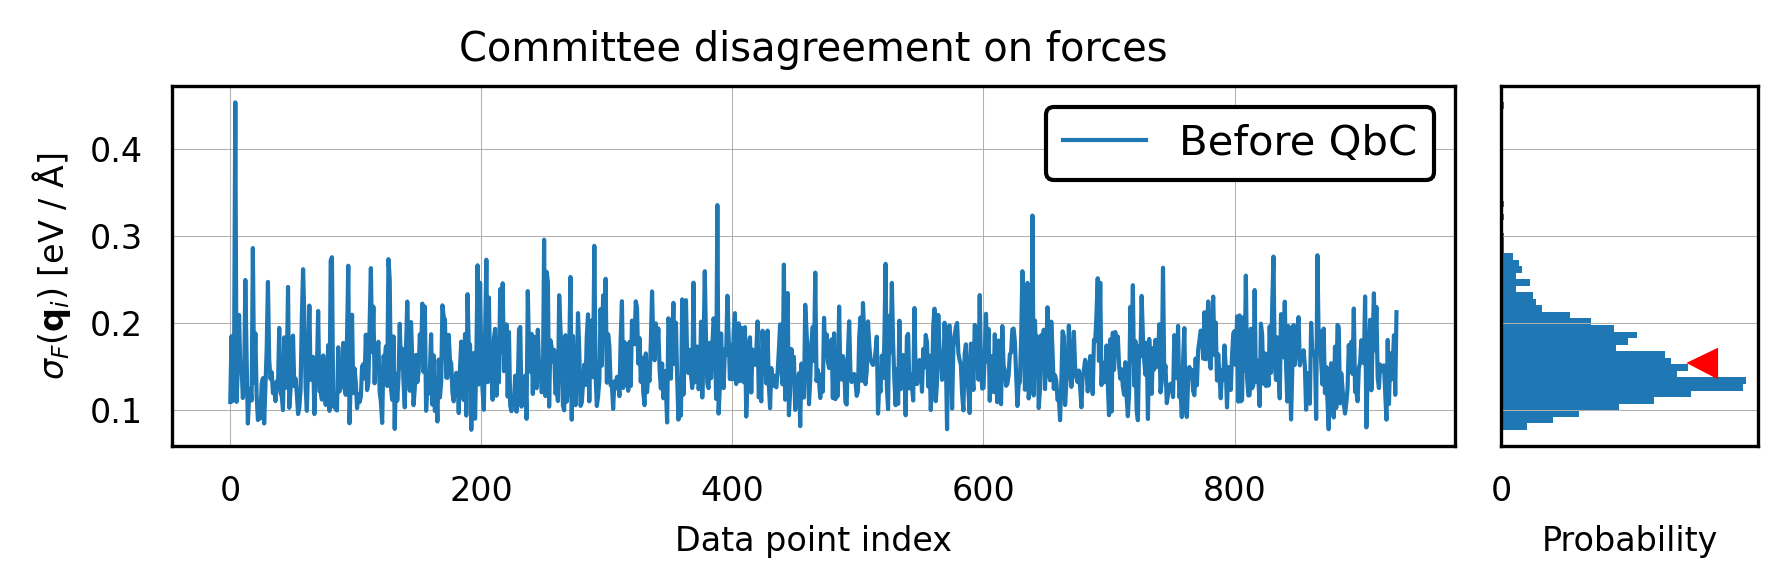

In [ ]:
# Predict with all MACE committee members
# README:
# - each model makes predictions on the same candidate structures
# - predictions are saved in separate files, one per model
# - we will later compare these predictions to measure model uncertainty ("disagreement")

for n in tqdm(range(n_committee)):
    eval_mace(f'{init_train_folder}/models/mace.com={n:d}_compiled.model',   # compiled model file
              'init-train/structures/candidates.extxyz',                     # input structures
              f'{init_train_folder}/eval/train_{n:02d}.extxyz')              # output prediction file

# load predicted forces from each model into a (n_committee, N_atoms, 3) array
forces = np.array([extxyz2array(f'{init_train_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_forces') 
                   for n in tqdm(range(n_committee))])

# average over atoms to get a single disagreement value per structure
disagreement = {}
disagreement['before qbc'] = 1000*forces2disagreement(forces)

# Plotting
# -------------------------

# create a 2-panel plot: (1) disagreement vs structure index, (2) histogram of disagreements
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))

# plot disagreement curve
ax[0].plot(disagreement['before qbc'], label='Before QbC')
ax[0].set_ylabel(r'$\sigma_F \left(\mathbf{q}_i\right)$ [meV / $\mathrm{\AA}$]')  # y-axis label: std. dev. of force
ax[0].set_xlabel('Data point index')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')
ax[0].legend()

# plot histogram of disagreement values
ax[1].hist(disagreement['before qbc'], bins=50, orientation='horizontal', density=True)
ax[1].plot(10, disagreement['before qbc'].mean(), '<', c='r')  # show average with a red triangle
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])  # only show one tick on x-axis for a clean look

plt.tight_layout()
plt.show()


### 1.5 Generalization error

Here, we will demonstrate that $\sigma_F$ is a *measure* of uncertainty, but is not equivalent to the **generalization error**, *i.e.*, the actual error of the model in prediction performed on previously unseen data.

In order to do this, we do an identical exercise as before: we let the committee predict on the remaining candidate structures, which will give us the predicted forces from which we derive the disagreement $\sigma_F$.

Then, since the initial candidate set is labeled, we take the **reference forces** and calculate the generalization as the RMSE
$$
\text{RMSE}_F\left(\mathbf{q}_i\right) =
\sqrt{\frac{1}{N} \sum_{\alpha=1}^{N} \left( \overline{\mathbf{F}}_\alpha - \mathbf{F}_\alpha^\text{ref} \right)^2}
$$

and simply correlate the two quantities.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

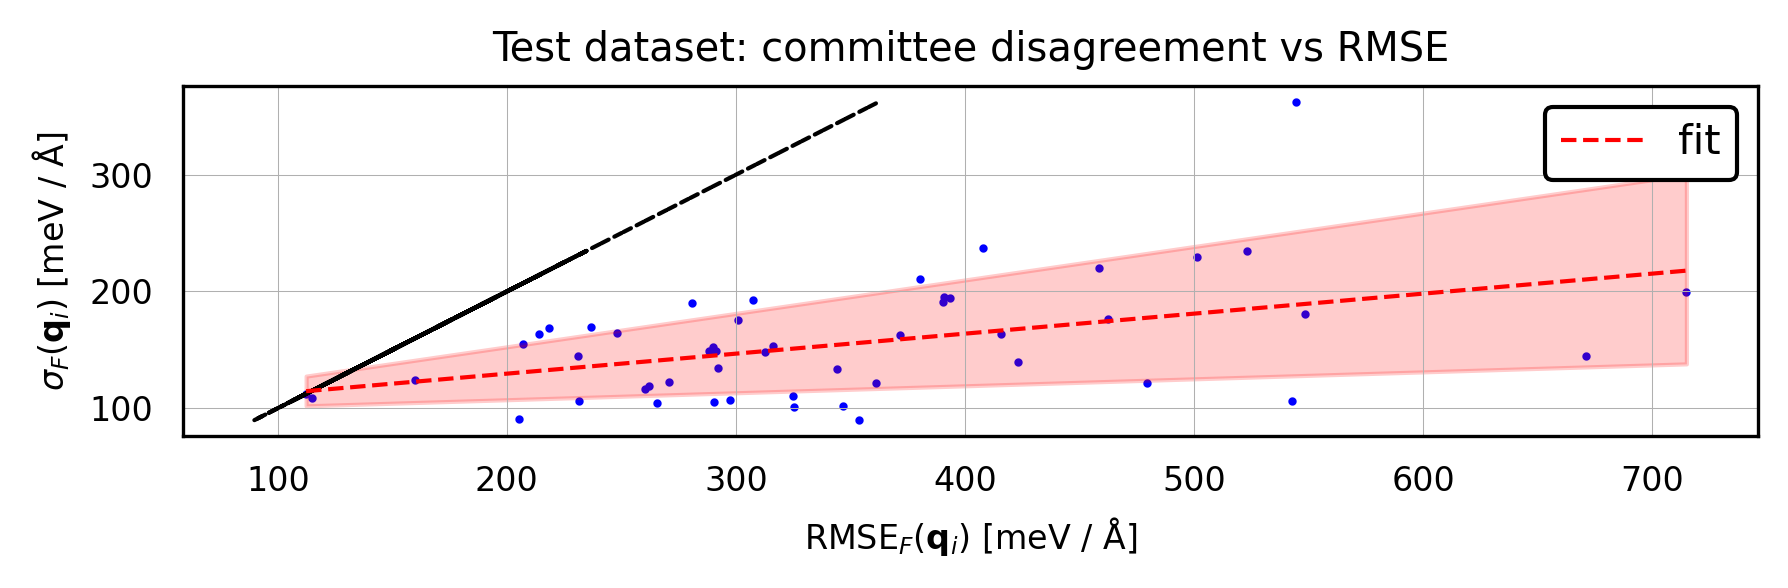

In [25]:
# Predict with all MACE committee members
# ---------------------------------------
# README:
# - each model makes predictions on the same test structures
# - predictions are saved in separate files (one per model)
# - we will compare these predictions to evaluate disagreement and RMSE vs reference

for n in tqdm(range(n_committee)):
    eval_mace(
        f'{init_train_folder}/models/mace.com={n:d}_compiled.model',   # compiled model file
        f'{init_train_folder}/structures/test.extxyz',                 # input structures
        f'{init_train_folder}/eval/test_{n:02d}.extxyz'                # output prediction file
    )

# Load predicted forces into shape: (n_committee, N_structures, N_atoms, 3)
mace_forces = np.array([
    extxyz2array(f'{init_train_folder}/eval/test_{n:02d}.extxyz', keyword='MACE_forces')
    for n in tqdm(range(n_committee))
])

# Load reference forces (e.g., from DFT): shape (N_structures, N_atoms, 3)
ref_forces = np.array(extxyz2array(f'{init_train_folder}/structures/test.extxyz', keyword='REF_forces'))

# Compute disagreement (std dev over committee) and RMSE (vs reference)
corr = {}
corr['sigma'] = 1000*forces2disagreement(mace_forces)         # σ: model disagreement per structure
corr['RMSE']  = 1000*forces2rmse(mace_forces, ref_forces)     # RMSE: vs. reference per structure

# Perform Theil–Sen regression: RMSE (x) → σ (y)
slope, intercept, lower, upper = theilslopes(corr['sigma'], corr['RMSE'])

# Plotting
# ---------------------------------------

# Diagonal line (for comparison only)
plt.plot(corr["sigma"], corr["sigma"], color='k', dashes=(2, 4), dash_capstyle='round')

# Scatter plot: RMSE vs σ
plt.scatter(corr["RMSE"], corr["sigma"], color="blue", s=1)

# Theil–Sen regression line
x_vals = np.linspace(min(corr["RMSE"]), max(corr["RMSE"]), 100)
plt.plot(x_vals, slope * x_vals + intercept, 'r--', label='fit')

# Uncertainty bounds
plt.fill_between(x_vals, lower * x_vals + intercept, upper * x_vals + intercept,
                 color='red', alpha=0.2)

# Labels and layout
plt.title("Test dataset: committee disagreement vs RMSE")
plt.xlabel(r'RMSE$_F\left(\mathbf{q}_i\right)$ [meV / $\mathrm{\AA}$]')
plt.ylabel(r'$\sigma_F \left(\mathbf{q}_i\right)$ [meV / $\mathrm{\AA}$]')
plt.legend()
plt.tight_layout()
plt.show()


## 2. Query by Committee (QbC)

At this point, we have an initial committee model that can predict $\sigma_F$ for arbitrary data points from the remaining candidate pool.

With this ability in our hands, we can now proceed to the actual execution of the QbC procedure.

There one iteratively predicts $\sigma_F$ over the remaining candidate pool, selects a fixed number of candidate geometries that feature the **highest** $\sigma_F$ and adds them to the training set and retrains the committee.

If you are curious about a detailed insight, have a look at the function `run_qbc()` contained in the `myfunctions.py` file. 


<figure style="text-align: center;">
    <img src="images/QbC3.png" alt="QbC" style="width:400px;">
    <figcaption style="font-style: italic; font-size: 90%;">Schematic representation of Query by Committee (QbC) active learning scheme showing the candidate pool and training pool selected based on committee uncertainity.</figcaption>
</figure>

In [7]:
# Run QbC

os.makedirs(qbc_folder, exist_ok=True)
os.makedirs(f'{qbc_folder}/config', exist_ok=True)

for i in range(n_committee):
    filename = f"{qbc_folder}/config/config.{i}.yml"
    
    prepare_train_file(template="train-template.yaml",
                        output_path=filename,
                        replacements={
                            "NAME" : f"mace.com={i}",
                            "TRAIN_FOLDER" : qbc_folder,
                            "SEED" : seeds[i],
                            "RESTART" : True,
                            "TRAIN_FILE":f"{qbc_folder}/train-iter.extxyz"
                        })

    print(f"Wrote '{filename}'")

Wrote 'qbc-work/config/config.0.yml'

Wrote 'qbc-work/config/config.1.yml'

Wrote 'qbc-work/config/config.2.yml'

Wrote 'qbc-work/config/config.3.yml'

In [ ]:
# run Query by Committee (QbC) to iteratively select structures
run_qbc(
    init_train_folder=init_train_folder,
    init_train_file=f"{init_train_folder}/structures/init.train.extxyz", # initial training dataset
    fn_candidates=f'{init_train_folder}/structures/candidates.extxyz',   # candidate structures
    test_dataset=f'{init_train_folder}/structures/test.extxyz',          # test set
    n_iter=n_iter_qbc,                                                   # number of QbC iterations
    config=f'{qbc_folder}/config',                                       # folder with config files
    ofolder=qbc_folder,                                                  # folder to save the QBC results
    n_add_iter=n_add_iter,                                               # number of structures to add in each iteration
    recalculate_selected=False,                                          # whether to recalculate the selected structures with DFT (part 2)
    parallel=parallel
);
# it should take 9m

### 2.1 Monitoring QbC convergence

How does one know when the QbC cycle has converged? Simply setting a threshold value for $\sigma_F$ is not the best idea since one does not *a priori* know what it should be.

A better way to look at it is to consider the QbC converged once all the *unlearned* information has been extracted from the candidate set and nothing new remains for the committee to learn.

To visualize this, we can plot the evolution of $\sigma_F$ for each new added batch of structures and see how that comes closer to the value of $\sigma_F$ averaged over the candidate pool.

In practice, one will be always selecting from the high-end tail of the disagreement distribution of the candidates, so one stops the QbC once those curves reach a plateau.

#### Forces disagreement

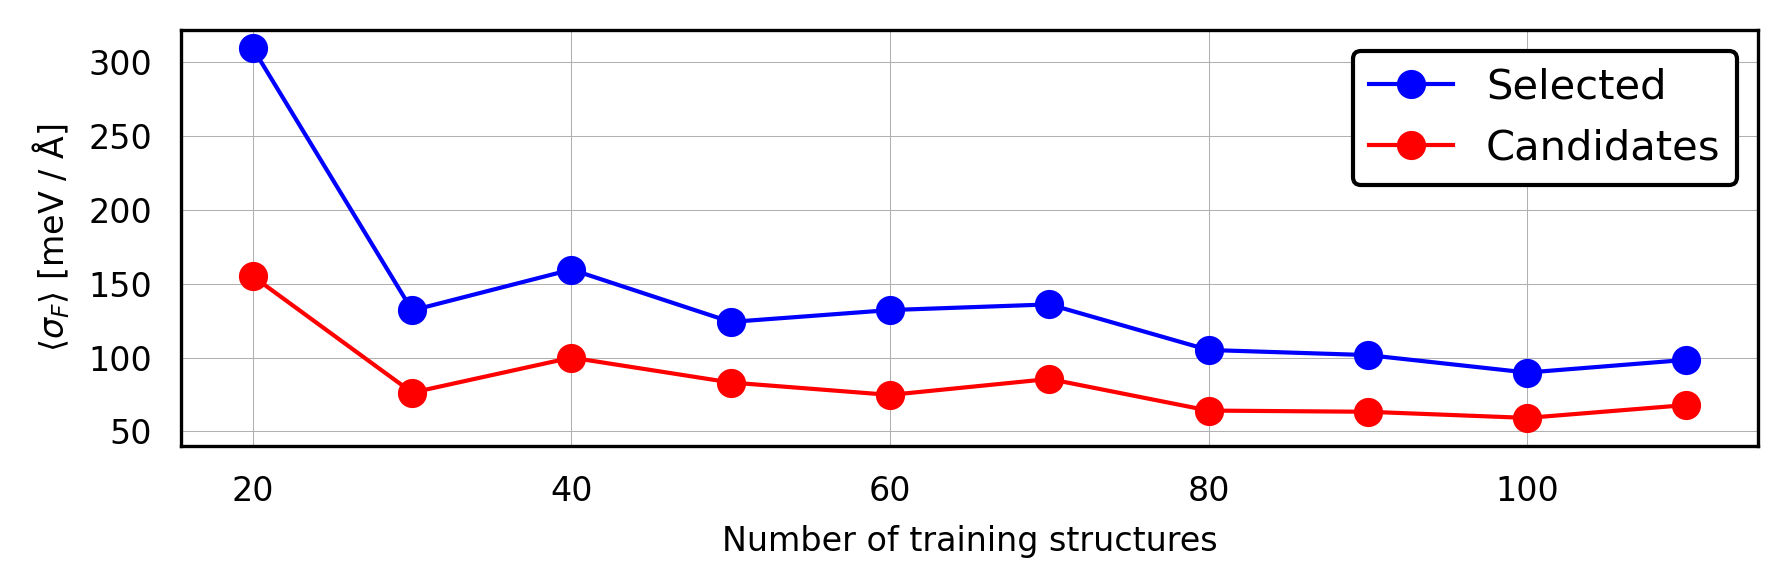

In [24]:
n_training_structures = np.arange(n_init_train, (n_iter_qbc * n_add_iter) + n_init_train, n_add_iter)
sigma = np.loadtxt('qbc-work/disagreement.txt').T

plt.plot(n_training_structures, 1000*sigma[0], '-o', label='Selected', color="blue")
plt.plot(n_training_structures, 1000*sigma[1], '-o', label='Candidates', color="red")
plt.legend()
plt.ylim(40,None)
plt.xlabel('Number of training structures')
plt.ylabel(r'$\langle \sigma_F \rangle$ [meV / $\mathrm{\AA}$]')
plt.tight_layout();

#### Generalization error

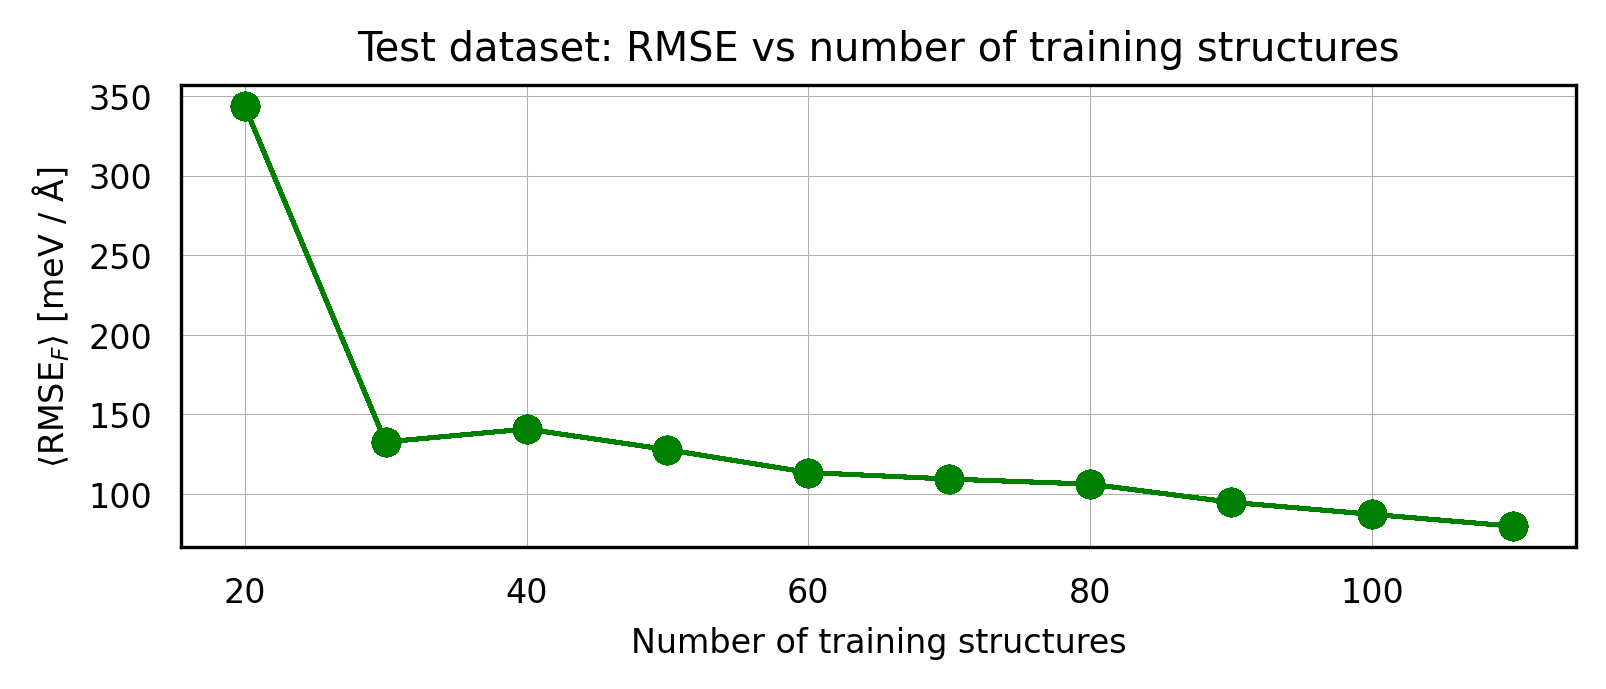

In [33]:
mace_forces = np.zeros((n_iter_qbc, n_committee, n_test, 7, 3))  # forces for each iteration
ref_forces = extxyz2array(f'{init_train_folder}/structures/test.extxyz', keyword='REF_forces')  # reference forces
assert ref_forces.shape == (n_test, 7, 3)  # check shape of reference forces

for i_iter in range(n_iter_qbc):
    predictions = [None] * n_committee
    for n_model in range(n_committee):
        file = f"{qbc_folder}/eval/test.model={n_model}.iter={i_iter}.extxyz"
        mace_forces[i_iter,n_model,:,:] = extxyz2array(file, keyword='MACE_forces')
# print(mace_forces.shape)  # should be (n_iter_qbc, n_committee, n_test, 7, 3)
assert np.isnan(mace_forces).sum() == 0  # check for NaN values

error = np.zeros((n_iter_qbc,n_test))
error_std = np.zeros((n_iter_qbc,n_test))
for i_iter in range(n_iter_qbc):
    rmse = 1000*forces2rmse(mace_forces[i_iter], ref_forces)
    error[i_iter] = np.mean(rmse)
    error_std[i_iter] = np.std(rmse)
    
n_training_structures = np.arange(n_init_train, (n_iter_qbc * n_add_iter) + n_init_train, n_add_iter)
plt.plot(n_training_structures, error, "-o", color="green")
plt.title("Test dataset: RMSE vs number of training structures")
plt.xlabel('Number of training structures')
plt.ylabel(r'$\langle \text{RMSE}_F \rangle$ [meV / $\mathrm{\AA}$]')
plt.show()

In [21]:
mode = "TRAIN"

# Load reference forces
ref_forces_test = np.array(extxyz2array(f'{init_train_folder}/structures/test.extxyz', keyword='REF_forces'))
# ref_forces_train = np.array(extxyz2array(f'{init_train_folder}/structures/candidates.extxyz', keyword='REF_forces'))

# Preload all predictions
all_sigma_test = []
all_rmse_test = []
all_sigma_train = []
all_rmse_train = []

for iteration in range(n_iter_qbc):
    mace_forces_test = np.array([
        extxyz2array(f"{qbc_folder}/eval/test.model={n}.iter={iteration}.extxyz", keyword='MACE_forces')
        for n in range(n_committee)
    ])
    mace_forces_train = np.array([
        extxyz2array(f"{qbc_folder}/eval/train.model={n}.iter={iteration}.extxyz", keyword='MACE_forces')
        for n in range(n_committee)
    ])
    
    ref_forces_train = extxyz2array(f"{qbc_folder}/eval/train.model=0.iter={iteration}.extxyz", keyword='REF_forces')
    
    # Test metrics
    sigma_test = 1000 * forces2disagreement(mace_forces_test)
    rmse_test = 1000 * forces2rmse(mace_forces_test, ref_forces_test)
    all_sigma_test.append(sigma_test)
    all_rmse_test.append(rmse_test)

    # Train metric
    sigma_train = 1000 * forces2disagreement(mace_forces_train)
    try:
        rmse_train = 1000 * forces2rmse(mace_forces_train, ref_forces_train)
    except:
        print("errror")
    all_sigma_train.append(sigma_train)
    all_rmse_train.append(rmse_train)

# Plot function with Theil–Sen regression (on test set)
def plot_corr(iteration):
    if mode == "TEST":
        sigma = all_sigma_test[iteration]
        rmse = all_rmse_test[iteration]
        color = 'blue'
        label = 'Test'
        cmap = 'Blues'
    elif mode == "TRAIN":
        sigma = all_sigma_train[iteration]
        rmse = all_rmse_train[iteration]
        color = 'red'
        label = 'Train'
        cmap = 'Reds'
    else:
        raise ValueError("mode must be either 'TEST' or 'TRAIN'")

    # Theil–Sen regression
    x_vals = np.linspace(0, 400, 100)

    # KDE
    xy = np.vstack([rmse, sigma])
    kde = gaussian_kde(xy)
    xgrid = np.linspace(0, 400, 100)
    ygrid = np.linspace(0, 250, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Plot
    plt.plot(x_vals, x_vals, color='black', linestyle='dashed')
    plt.scatter(rmse, sigma, color=color, s=1, label=label)

    levels = np.linspace(Z.min(), Z.max(), 7)[1:]  # Skip lowest level
    plt.contour(X, Y, Z, levels=levels, cmap=cmap, alpha=0.7)

    plt.xlim(0, 400)
    plt.ylim(0, 250)
    plt.title(f"Iteration {iteration}: Committee Disagreement vs RMSE ({label})")
    plt.xlabel(r'RMSE$_F(\mathbf{q}_i)$ [meV / $\mathrm{\AA}$]')
    plt.ylabel(r'$\sigma_F(\mathbf{q}_i)$ [meV / $\mathrm{\AA}$]')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Slider for iteration
interact(plot_corr, iteration=IntSlider(min=0, max=n_iter_qbc - 1, step=1, value=0, description='Iteration'))


interactive(children=(IntSlider(value=0, description='Iteration', max=9), Output()), _dom_classes=('widget-int…

<function __main__.plot_corr(iteration)>

A correlation is clear. This makes sense, since the two quantities are related by their physical meaning, but they are nowhere near identical.

## 3. Zundel cation inference simulation

### 3.1 Inference

We have reached a point at which we have a trained committee model that can be used as a potential energy surface to drive MD simulations.

Now, we will run a simple classical NVT simulation at 300 K using the `i-PI` software and monitor the force disagreement along the trajectory.

### 3.2 Steps to perform inference MD simulation using the committee of machine learning potential

**Step 1. Copy Committee Models**

Copy all the ML models generated via Query-by-Committee (QbC) into the `ipi-examples/zundel-inference` folder 

    `for i in {0..3..1} ; do cp  qbc-work/models/mace.com=${i}_compiled.model ../ipi-examples/zundel-inference/.; done`

**Step 2. Navigate to inference directory**

    `cd ../ipi-examples/zundel-inference/`

**Step 3. Overview of inference directory**

Lets look all the files one by one

3.1 `input.xml` -> input file for i-pi - contains all MD simulation settings, including ensemble, temperature, and reference to the committee models.


<figure style="text-align: center;">
    <img src="images/ffsocket2.png" alt="ffsocket" style="width:400px;">
    <figcaption style="font-style: italic; font-size: 90%;">ffsocket: This is a tag which allows i-pi to communicate with machine learned potentials in the committee.</figcaption>
</figure>

<figure style="text-align: center;">
    <img src="images/ffsocket_weight.png" alt="ffsocket_weight" style="width:400px;">
    <figcaption style="font-style: italic; font-size: 90%;">This section allows us to drive the MD with the mean of committee. Here, we have 4 committee MLIPs so to compute the average we put weight of 0.25 on each MLIP.</figcaption>
</figure>

3.2 `start.extxyz` -> input structure in extxyz format (here a zundel cation) - input geometry for the simulation.
    
3.3 `run.sh` -> bash script to run MD with committee.

3.4 `post-process.py` -> removes the lattice for clean visualization 

**Step 4. Run the MD simulation with the committee**

    `./run.sh`

**Step 5. Post-process the trajectory** 

Now after the finising the MD, we clean up the output trajectory file for better visualization

    `python ../post-process.py -i ipi.pos_0.extxyz -o zundel-inference.extxyz`

**Step 6. Visualize the trajectory**

    `ase gui zundel-inference.extxyz`


### 3.3 Monitoring the disagreement along the trajectory

Now that our simulation is finished, we will have a look at how our committee performed.
The $\sigma_F$ is an extremely useful measure of simulation stability and monitioring is along the way quickly allows one to discover when the model starts to extrapolate and yield potentially unphysical predictions.

How does the disagreement evolution look? Do you see any sudden jumps, or does the disagreement oscillate around an average value but does not significantly change?

  0%|          | 0/4 [00:00<?, ?it/s]

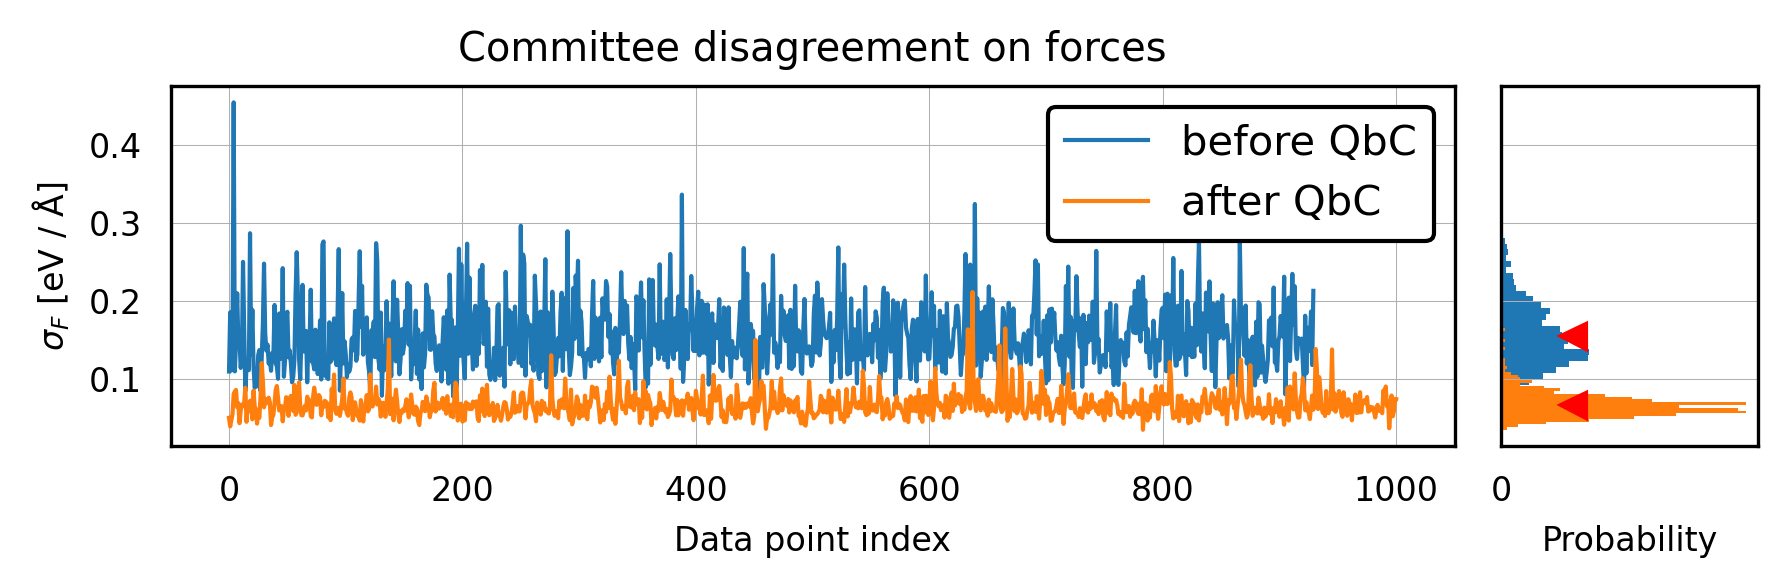

In [27]:
forces = np.array([extxyz2array(f'../ipi-examples/zundel-inference/ipi.mace_force_{n:d}.extxyz', 
                                keyword='forces_component_raw') 
                   for n in tqdm(range(n_committee))])

# README: disagreement was defined in Section 1.4
disagreement['after qbc'] = forces2disagreement(forces)

# check that these parameters are the same as in input.xml
dt = 0.5e-3 # ps
stride = 20 # steps

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))
ax[0].plot(disagreement['before qbc'], label='before QbC')
ax[0].plot(disagreement['after qbc'], label='after QbC')
ax[0].set_ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
ax[0].set_xlabel('Data point index')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')
ax[0].legend()

ax[1].hist(disagreement['before qbc'], bins=50, orientation='horizontal', density=True)
ax[1].plot(10, disagreement['before qbc'].mean(), '<', c='r')
ax[1].hist(disagreement['after qbc'], bins=50, orientation='horizontal', density=True)
ax[1].plot(10, disagreement['after qbc'].mean(), '<', c='r')
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])

plt.tight_layout();